In [19]:
import tensorflow as tf

tf.__version__

d:\anaconda3\envs\csdlpt\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\anaconda3\envs\csdlpt\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\anaconda3\envs\csdlpt\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\anaconda3\envs\csdlpt\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

'1.14.0'

In [14]:
import imutils
import numpy as np
import cv2

In [15]:
image_file = "img_via.jpg"

In [16]:
print("[INFO] loading model...")
prototxt = 'utils/deploy.prototxt'
model = 'utils/res10_300x300_ssd_iter_140000.caffemodel'
face_detect_net = cv2.dnn.readNetFromCaffe(prototxt, model)

[INFO] loading model...


In [17]:
img = cv2.imread(image_file)

image = img.copy()

(h_img, w_img) = image.shape[:2]
blob = cv2.dnn.blobFromImage(img, 1.0, (300, 300), (104.0, 177.0, 123.0))
face_detect_net.setInput(blob)
detections = face_detect_net.forward()

rects = []
i = 0

global LIST_FACES
LIST_FACES = []

global LIST_EMB_FACES
LIST_EMB_FACES = {}

for i in range(0, detections.shape[2]):
        # extract the confidence (i.e., probability) associated with the prediction
        confidence = detections[0, 0, i, 2]
        # filter out weak detections by ensuring the `confidence` is
        # greater than the minimum confidence threshold
        if confidence > 0.2:
            # compute the (x, y)-coordinates of the bounding box for the object
            # box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            # (startX, startY, endX, endY) = box.astype("int")
            # print((startX, startY, endX, endY))
            # # draw the bounding box of the face along with the associated probability
            # text = "{:.2f}%".format(confidence * 100)
            # y = startY - 10 if startY - 10 > 10 else startY + 10
            # cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
            # cv2.putText(image, text, (startX, y),
            # cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)


            box = detections[0, 0, i, 3:7] * np.array([w_img, h_img, w_img, h_img])
            (startX, startY, endX, endY) = box.astype("int")
            print((startX, startY, endX, endY))
            x = startX
            y = startY
            w = endX - startX
            h = endY - startY
            rects.append((x, y, w, h))
            print((x, y, w, h))
            print()
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.putText(image, "#{} - {:.2f}%".format(i + 1, confidence * 100), (x - 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            # cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            face_image = image[y:y+h, x:x+w]
            face_image = cv2.resize(face_image, (200, 200))
            LIST_FACES.append(face_image)

(579, 220, 730, 401)
(579, 220, 151, 181)

(653, 462, 802, 664)
(653, 462, 149, 202)

(916, 109, 1092, 346)
(916, 109, 176, 237)

(406, 340, 589, 567)
(406, 340, 183, 227)

(804, 426, 975, 651)
(804, 426, 171, 225)



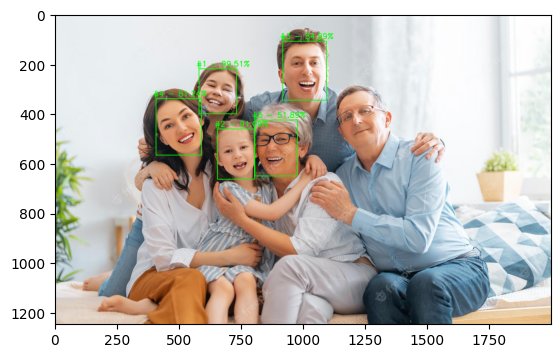

In [18]:
%matplotlib inline
#The line above is necesary to show Matplotlib's plots inside a Jupyter Notebook

import cv2
from matplotlib import pyplot as plt

#Show the image with matplotlib
plt.imshow(image)
plt.show()